In [1]:
import os
import meld
import numpy as np
import pandas as pd
import scanpy as sc
sc.set_figure_params()
import anndata as ad

from collections import OrderedDict
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### set params for meld
beta = 10  # amount of smoothing to apply
knn = 4  # number of neighbors to use

### SetAE Methods

#### FSPool + FSUPool

In [3]:
adata_fspool = ad.read_h5ad('../results/dl/bcr_xl/fspool/latent.h5ad')

scaler = preprocessing.StandardScaler().fit(adata_fspool.X)
adata_fspool.X = scaler.transform(adata_fspool.X)

In [4]:
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_fspool.X, adata_fspool.obs['phenotype'].values)
prob_fspool = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


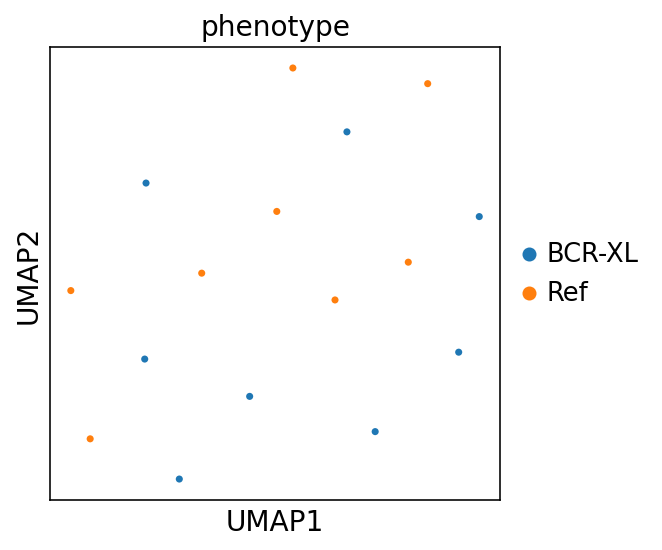

In [5]:
sc.pp.neighbors(adata_fspool, use_rep='X')
sc.tl.umap(adata_fspool)

with rc_context({'figure.figsize': (4, 4)}):
    fig, ax = plt.subplots(1, 1)
    sc.pl.umap(
        adata_fspool,
        color='phenotype',
        size=50,
        frameon=True,
        ax=ax
    )

#### Max + MLP

In [6]:
adata_maxmlp = ad.read_h5ad('../results/dl/bcr_xl/max_mlp/latent.h5ad')

scaler = preprocessing.StandardScaler().fit(adata_maxmlp.X)
adata_maxmlp.X = scaler.transform(adata_maxmlp.X)

In [7]:
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_maxmlp.X, adata_maxmlp.obs['phenotype'].values)
prob_maxmlp = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


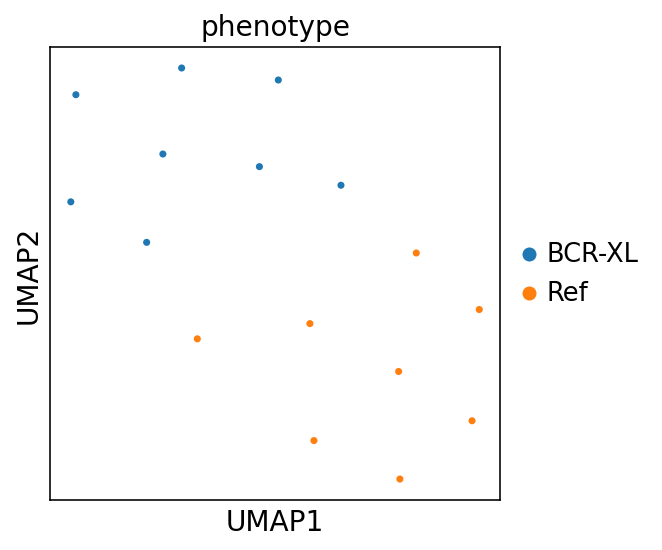

In [8]:
sc.pp.neighbors(adata_maxmlp, use_rep='X')
sc.tl.umap(adata_maxmlp)

with rc_context({'figure.figsize': (4, 4)}):
    fig, ax = plt.subplots(1, 1)
    sc.pl.umap(
        adata_maxmlp,
        color='phenotype',
        size=50,
        frameon=True,
        ax=ax
    )

#### Mean + MLP

In [9]:
adata_meanmlp = ad.read_h5ad('../results/dl/bcr_xl/mean_mlp/latent.h5ad')

scaler = preprocessing.StandardScaler().fit(adata_meanmlp.X)
adata_meanmlp.X = scaler.transform(adata_meanmlp.X)

In [10]:
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_meanmlp.X, adata_meanmlp.obs['phenotype'].values)
prob_meanmlp = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 8 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


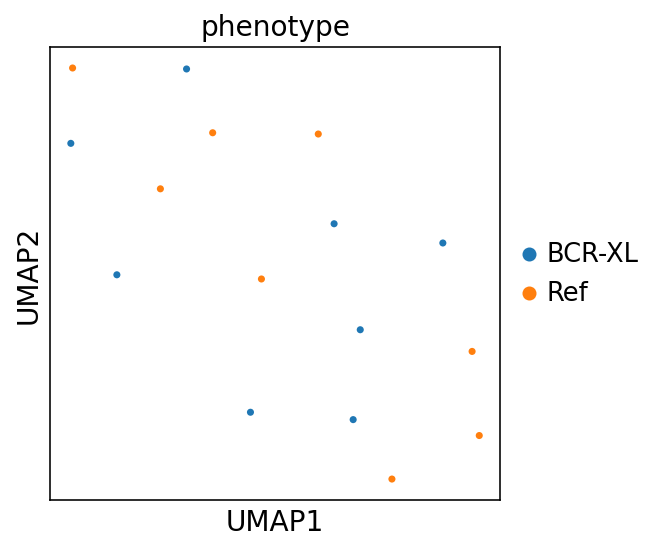

In [11]:
sc.pp.neighbors(adata_meanmlp, use_rep='X')
sc.tl.umap(adata_meanmlp)

with rc_context({'figure.figsize': (4, 4)}):
    fig, ax = plt.subplots(1, 1)
    sc.pl.umap(
        adata_meanmlp,
        color='phenotype',
        size=50,
        frameon=True,
        ax=ax
    )

### CytoEMD Method

In [12]:
adata_cytoemd = ad.read_h5ad("../results/bcr_xl_cytoemd.h5ad")
scaler = preprocessing.StandardScaler().fit(adata_cytoemd.X)
adata_cytoemd.X = scaler.transform(adata_cytoemd.X)

### get predicted probability
prob_density = meld.MELD(
    beta=beta, knn=knn, sample_normalize=True
).fit_transform(adata_cytoemd.X, adata_cytoemd.obs['phenotype'].values)
prob_cytoemd = meld.utils.normalize_densities(prob_density)

Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


### ROC-AUC

In [13]:
### ROC CytoEMD
fpr_fspool, tpr_fspool, _ = metrics.roc_curve(
    adata_fspool.obs['phenotype'].values,
    prob_fspool['BCR-XL'], pos_label='BCR-XL'
)
auc_fspool = metrics.auc(fpr_fspool, tpr_fspool)

fpr_maxmlp, tpr_maxmlp, _ = metrics.roc_curve(
    adata_maxmlp.obs['phenotype'].values,
    prob_maxmlp['BCR-XL'], pos_label='BCR-XL'
)
auc_maxmlp = metrics.auc(fpr_maxmlp, tpr_maxmlp)

fpr_meanmlp, tpr_meanmlp, _ = metrics.roc_curve(
    adata_meanmlp.obs['phenotype'].values,
    prob_meanmlp['BCR-XL'], pos_label='BCR-XL'
)
auc_meanmlp = metrics.auc(fpr_meanmlp, tpr_meanmlp)

fpr_cytoemd, tpr_cytoemd, _ = metrics.roc_curve(
    adata_cytoemd.obs['phenotype'].values,
    prob_cytoemd['BCR-XL'], pos_label='BCR-XL'
)
auc_cytoemd = metrics.auc(fpr_cytoemd, tpr_cytoemd)

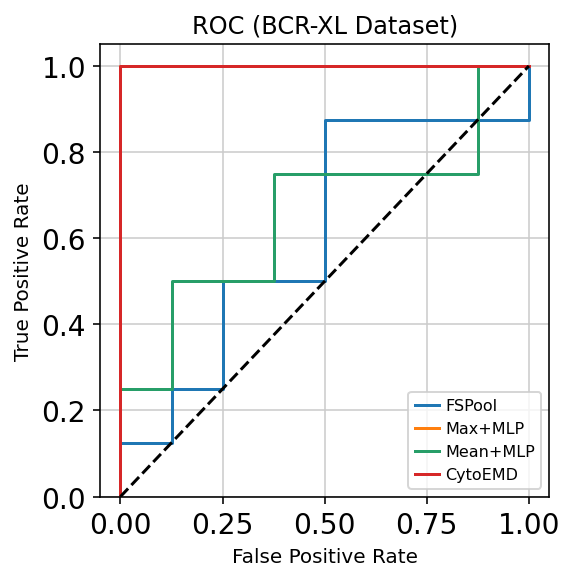

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# plot the roc curve
ax.plot(fpr_fspool,  tpr_fspool,  label='FSPool')
ax.plot(fpr_maxmlp,  tpr_maxmlp,  label='Max+MLP')
ax.plot(fpr_meanmlp, tpr_meanmlp, label='Mean+MLP')
ax.plot(fpr_cytoemd, tpr_cytoemd, label='CytoEMD')

# add settings
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=10)
ax.set_ylabel("True Positive Rate", fontsize=10)
ax.set_title('ROC (BCR-XL Dataset)', fontsize=12)
ax.grid(":")
ax.legend(loc='best', handlelength=1.5, fontsize=8)

# plot y = x line
ax.plot([0, 1], [0, 1], 'k--')
plt.show()

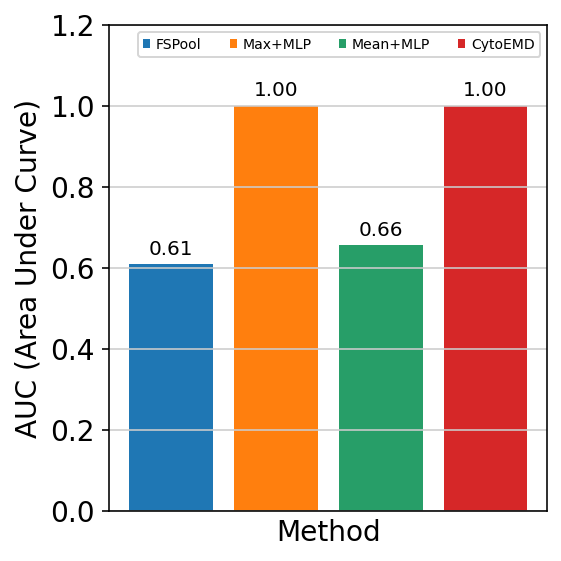

In [15]:
### AUC Barplot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

labels = ['FSPool', 'Max+MLP', 'Mean+MLP', 'CytoEMD']
width = 0.8
x = np.arange(4)

rec1 = ax.bar(x[0], auc_fspool,  label=labels[0], )
rec2 = ax.bar(x[1], auc_maxmlp,  label=labels[1], )
rec3 = ax.bar(x[2], auc_meanmlp, label=labels[2], )
rec4 = ax.bar(x[3], auc_cytoemd, label=labels[3], )

ax.set_ylim([0, 1.2])
ax.set_xlabel("Method")
ax.set_ylabel("AUC (Area Under Curve)")
# ax.set_title("AUC of Different Methods")
ax.set_xticks([])
# ax.set_xticklabels(labels, rotation=45, fontsize=8)
ax.grid(':')
ax.legend(loc='best', fontsize=7, ncol=4)

ax.bar_label(rec1, fmt="%.2f", padding=3)
ax.bar_label(rec2, fmt="%.2f", padding=3)
ax.bar_label(rec3, fmt="%.2f", padding=3)
ax.bar_label(rec4, fmt="%.2f", padding=3)

plt.tight_layout()
plt.show()

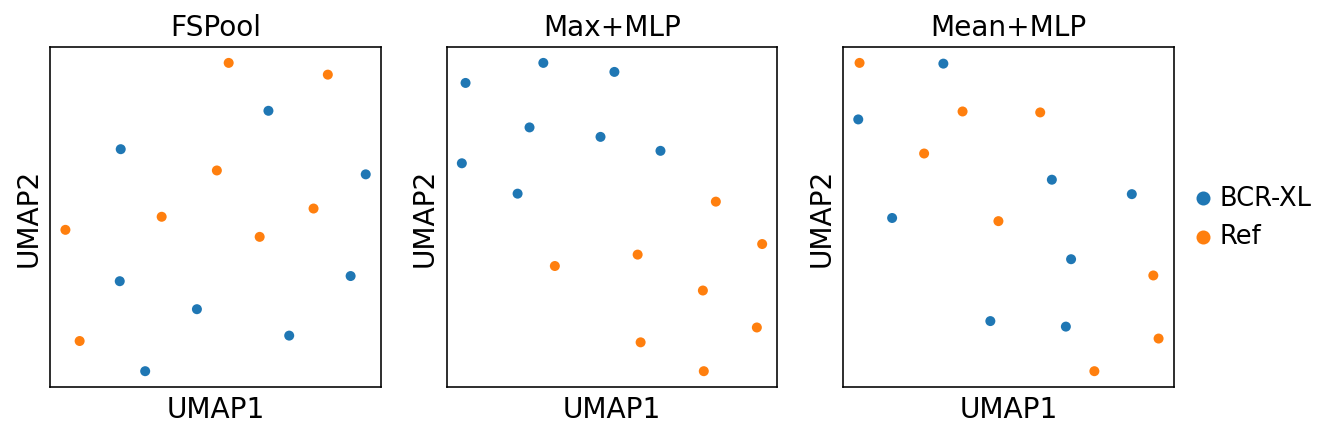

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))

ax1_dict = sc.pl.umap(adata_fspool,  color='phenotype', size=100, show=False, ax=ax1, title='FSPool', legend_loc=None)
ax2_dict = sc.pl.umap(adata_maxmlp,  color='phenotype', size=100, show=False, ax=ax2, title='Max+MLP', legend_loc=None)
ax3_dict = sc.pl.umap(adata_meanmlp, color='phenotype', size=100, show=False, ax=ax3, title='Mean+MLP')

# plt.savefig('./Res_UMAP.png', dpi=200, facecolor='white', bbox_inches='tight')